In [1]:
suppressPackageStartupMessages(suppressWarnings(library(lintr))) # linting
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # used to attach multiple figures into one
suppressPackageStartupMessages(library(png)) # allows to load in figures in memory

In [2]:
# helper functions
load_image <- function(path) {
    img <- png::readPNG(path)
    # Convert the image to a raster object
    g <- grid::rasterGrob(img, interpolate = TRUE)

    # Create a ggplot
    p <- ggplot() +
        annotation_custom(g, xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf) +
        theme_void()
    return(p)
}

In [3]:
# getting all paths
# confusing matrix paths
confusion_matrix_path <- file.path("../../results/2.modeling/confusion_matrix.csv.gz")

# f1 score path
f1_score_path <- file.path("../../results/2.modeling/all_f1_scores.csv.gz")

# precision and recall curve path
pr_file_path <- file.path("../../results/2.modeling/precision_recall_scores.csv.gz")

# probability plot
cyto_proba_path <- file.path("../../results/3.jump_analysis/cytoskeletal_proba_scores.csv.gz")

# injury probabilities
injury_proba_path <- file.path("../../results/3.jump_analysis/all_injury_proba.csv.gz")

# path to workflow image
wf_image <- file.path("./figures/workflow_fig.png")

# create figures and supplemental dir
dir.create("figures/supplemental", recursive = TRUE)


Warning message in dir.create("figures/supplemental", recursive = TRUE):
“'figures/supplemental' already exists”


In [4]:
# loading all data
# loading confusion matrices
cm_df <- read.csv(confusion_matrix_path, sep = ",")

# loading f1 score paths
f1_df <- read.csv(f1_score_path, sep = ",")

# loading pr curve data
pr_df <- read.csv(pr_file_path)

# loading probabilities
cyto_proba_df <- read.csv(cyto_proba_path)

all_injury_proba_df <- read.csv(injury_proba_path)

# loading workflow image
fig2_A_wf_image <- load_image(wf_image)

In [5]:
# pre-formatting data before plotting
# Update 'shuffled_model' column in cm_df
# rename Nonspecific reactive to Nonspecific
cm_df <- cm_df %>%
  mutate(
    shuffled_model = case_when(
      shuffled_model == "False" ~ "Not Shuffled",
      shuffled_model == "True" ~ "Shuffled",
      TRUE ~ shuffled_model
    ),
    true_labels = ifelse(true_labels == "Nonspecific reactive", "Nonspecific", true_labels),
    predicted_labels = ifelse(predicted_labels == "Nonspecific reactive", "Nonspecific", predicted_labels)
  )

# Update 'shuffled' column in f1_df
# rename Nonspecific reactive to Nonspecific
f1_df <- f1_df %>%
  mutate(
    shuffled = case_when(
      shuffled == "False" ~ "Not Shuffled",
      shuffled == "True" ~ "Shuffled",
      TRUE ~ shuffled
    ),
    injury_type = ifelse(injury_type == "Nonspecific reactive", "Nonspecific", injury_type)
  )

# update one of the shuffled_model columns to Shuffled and Not Shuffled
# rename Nonspecific reactive to Nonspecific
pr_df <- pr_df %>%
  mutate(
    shuffled = case_when(
      shuffled == "False" ~ "Not Shuffled",
      shuffled == "True" ~ "Shuffled",
      TRUE ~ shuffled
    ),
    injury_type = ifelse(injury_type == "Nonspecific reactive", "Nonspecific", injury_type)
  )

# Update 'shuffled_model' column in proba_df
# rename Nonspecific reactive to Nonspecific
cyto_proba_df <- cyto_proba_df %>%
  mutate(shuffled = replace(shuffled, shuffled == "False", "Not Shuffled"),
         shuffled = replace(shuffled, shuffled == "True", "Shuffled"))

# Adding the new column based on the condition
cyto_proba_df <- cyto_proba_df %>%
  mutate(injury = ifelse(grepl('Cytoskeletal', pred_injury), 'Cyto Injury', 'Other Injuries'))

## Update the 'injury' column based on 'datatype' condition
cyto_proba_df <- cyto_proba_df %>%
  mutate(injury = ifelse(datatype == "JUMP Overlap", "Cyto JUMP Overlap", injury))


# Update injury proba columns
all_injury_proba_df <- all_injury_proba_df %>%
  mutate(shuffled = replace(shuffled, shuffled == "False", "Not shuffled"),
         shuffled = replace(shuffled, shuffled == "True", "Shuffled"),
         pred_injury = replace(pred_injury, pred_injury == "Nonspecific reactive", "Nonspecific"),
         injury_compared_to = replace(injury_compared_to, injury_compared_to == "Nonspecific reactive", "Nonspecific"))

## Figure 2 Panel A: Workflow Diagram

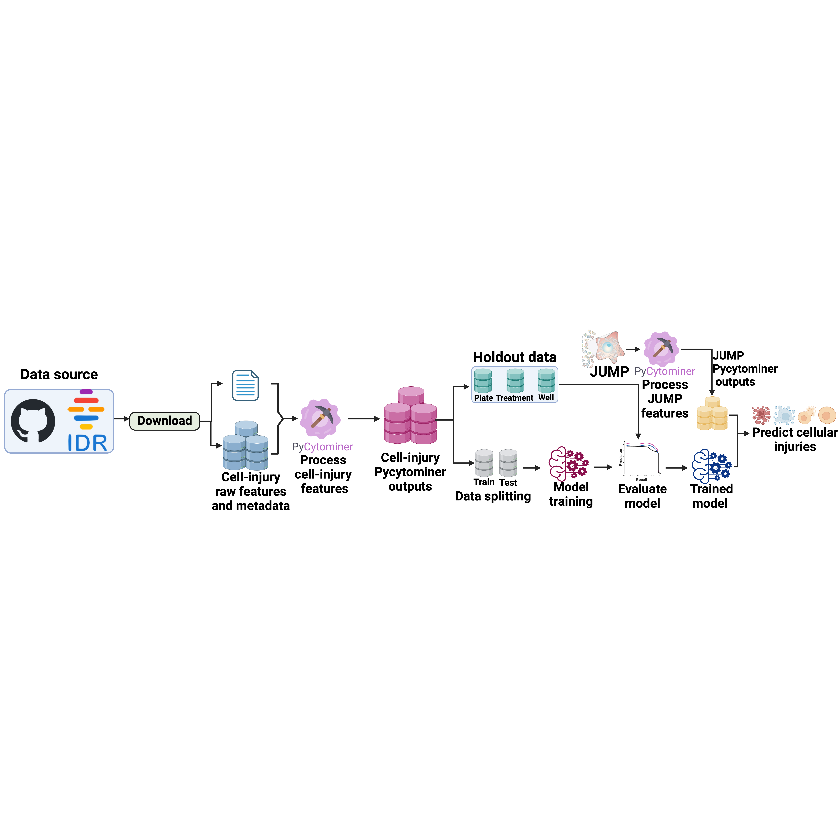

In [6]:
fig2_A_wf_image

## Figure 2 Panel B: PR Cruves for Train and Test split

In [7]:
# Selecting only the Test and Train data splits PR curves
test_train_pr <- pr_df %>%
  filter(dataset_type %in% c("Test", "Train"))

# Selecting only the F1 scores both both testing and training split in the Non-shuffled model
test_train_f1_df <- f1_df %>%
  filter(dataset_type %in% c("Test", "Train"), shuffled == "Not Shuffled")

# Merging both dataframes; However, if the Model is shuffled f1 score will be NaN
pr_f1_curve <- merge(test_train_pr, test_train_f1_df, by = c("dataset_type", "shuffled", "injury_type"), all = TRUE)

# Filtering to only get Test and Train Not shuffled f1 scores
f1_scores_per_injury_df <- pr_f1_curve[, c("dataset_type", "shuffled", "injury_type", "f1_score")] %>%
  filter(dataset_type %in% c("Train", "Test"), shuffled == "Not Shuffled") %>%
  distinct()

# Dropping columns that are no longer needed
f1_scores_per_injury_df <- select(f1_scores_per_injury_df, -shuffled)
f1_scores_per_injury_df$f1_score <- round(f1_scores_per_injury_df$f1_score, 2)

# Filter rows where dataset_type is "Train" and select only the columns we need
train_data <- f1_scores_per_injury_df %>%
  filter(dataset_type == "Train") %>%
  select(injury_type, f1_score) %>%
  rename(train_f1_score = f1_score)

# Merge the filtered dataframe with the original one based on injury_type
f1_scores_per_injury_df <- f1_scores_per_injury_df %>%
  filter(dataset_type == "Test") %>%
  left_join(train_data, by = "injury_type") %>%
  rename(test_f1_score = f1_score) %>%
  select(-dataset_type)


In [8]:
# These values manually move the F1 score box within each subplot.
# The position of these values corresponds to the row of the table below.
x_values <- c(0.50, 0.50, 0.35, 0.30, 0.50, 0.50, 0.40, 0.70, 0.40, 0.40, 0.70, 0.35, 0.74, 0.74, 0.74)
y_values <- c(0.25, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.80, 0.50, 0.90, 0.90, 0.90)

# generate dataframe responsible for placing the f1 boxes within the plot
f1_scores_per_injury_df <- f1_scores_per_injury_df %>%
  mutate(
    f1_label = paste0(
      "F1 Train:", sprintf("%.2f", train_f1_score), "\n",
      "F1 Test:", sprintf("%.2f", test_f1_score)
    ),
    x = x_values,
    y = y_values
  )

f1_scores_per_injury_df


injury_type   test_f1_score train_f1_score f1_label                    x   
1  Control       0.79          0.80           F1 Train:0.80\nF1 Test:0.79 0.50
2  Cytoskeletal  0.94          0.94           F1 Train:0.94\nF1 Test:0.94 0.50
3  Ferroptosis   0.44          0.40           F1 Train:0.40\nF1 Test:0.44 0.35
4  Genotoxin     0.67          0.73           F1 Train:0.73\nF1 Test:0.67 0.30
5  HDAC          0.79          0.88           F1 Train:0.88\nF1 Test:0.79 0.50
6  Hsp90         0.82          0.77           F1 Train:0.77\nF1 Test:0.82 0.50
7  Kinase        0.63          0.63           F1 Train:0.63\nF1 Test:0.63 0.40
8  Miscellaneous 0.33          0.33           F1 Train:0.33\nF1 Test:0.33 0.70
9  Mitochondria  0.67          0.62           F1 Train:0.62\nF1 Test:0.67 0.40
10 mTOR          0.67          0.71           F1 Train:0.71\nF1 Test:0.67 0.40
11 Nonspecific   0.29          0.33           F1 Train:0.33\nF1 Test:0.29 0.70
12 Proteasome    0.68          0.74           F1 Train:0.74\nF1 Test:0.68 0.35
13 Redox         0.46          0.39           F1 Train:0.39\nF1 Test:0.46 0.74
14 Saponin       0.21          0.22           F1 Train:0.22\nF1 Test:0.21 0.74
15 Tannin        0.09          0.10           F1 Train:0.10\nF1 Test:0.09 0.74
   y   
1  0.25
2  0.50
3  0.50
4  0.50
5  0.50
6  0.50
7  0.50
8  0.50
9  0.50
10 0.50
11 0.80
12 0.50
13 0.90
14 0.90
15 0.90

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


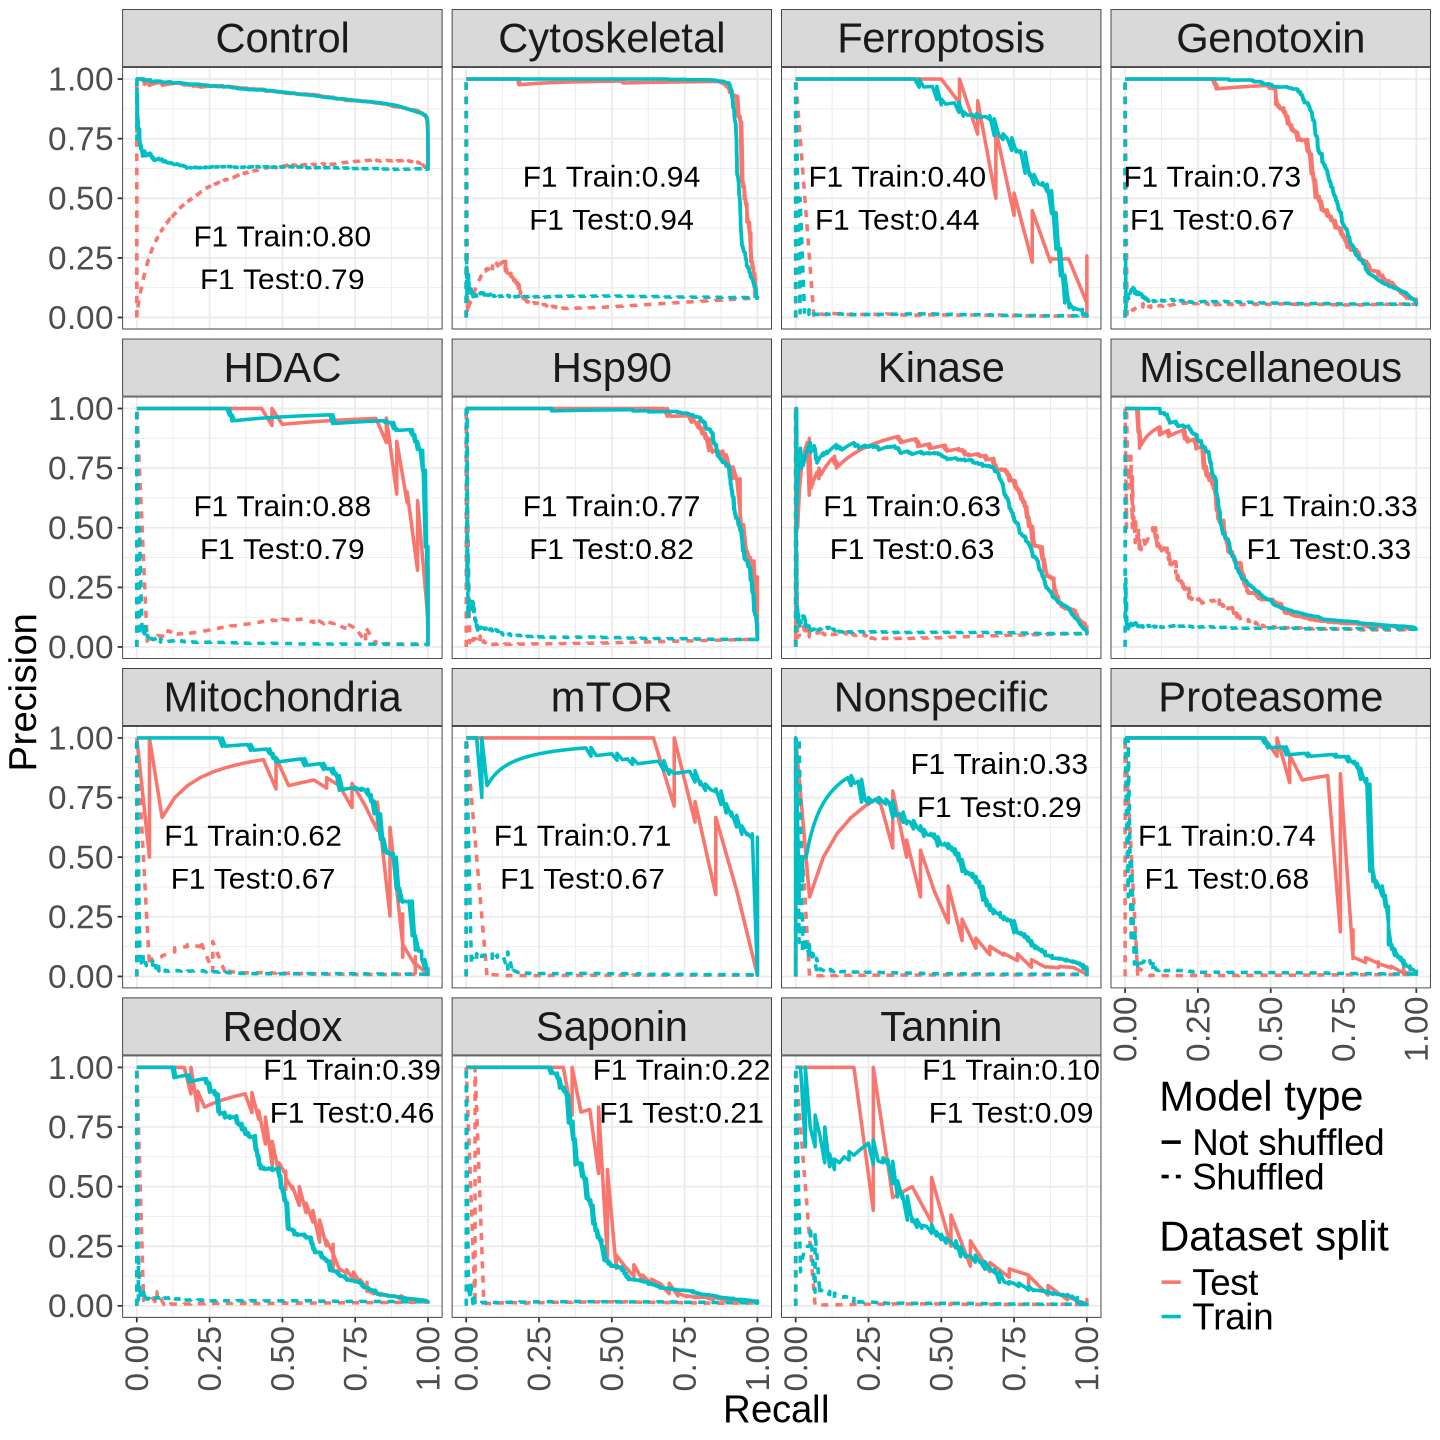

In [9]:
# plot data
width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

# Updating label names
pr_f1_curve <- pr_f1_curve %>%
  mutate(shuffled = ifelse(shuffled == "Not Shuffled", "Not shuffled", shuffled))

# # original
fig2_B_pr_curve_plot_train_test <- ggplot(pr_f1_curve, aes(x = recall, y = precision)) +
  geom_line(aes(color = dataset_type, linetype = shuffled), size = 1) +
  facet_wrap(~injury_type) +
  xlab("Recall") +
  ylab("Precision") +
  theme_bw() +
  theme(
    legend.spacing.y = unit(0.1, "cm"),
    legend.box.spacing = unit(0.1, "cm"),
    legend.key.size = unit(0.7, "lines"),
    legend.key.width = unit(1, "lines"),
    axis.text.x = element_text(angle = 90, vjust = 0.5, size = 20),
    axis.text.y = element_text(size = 20),
    strip.text = element_text(size = 25),
    strip.text.x = element_text(margin = margin(t = 0.2, b = 0.2, r = 0, l = 0, "cm")),
    axis.title = element_text(size = 23),
    legend.title = element_text(size = 25),
    legend.text = element_text(size = 22),
    legend.position = c(0.88, 0.09)
  ) +
  # adding labels within the facet
  geom_point(
    data = f1_scores_per_injury_df,
    aes(x = x, y = y),
    shape = 32,
  ) +
  geom_text(
    data = f1_scores_per_injury_df,
    aes(x = x, y = y, label = f1_label),
    hjust = 0.5, # Center horizontally
    vjust = 0.5, # Adjust vertically for position
    size = 6.3, # Increase font size
    color = "black", # Text color
    show.legend = FALSE # Hide legend for this layer
  ) +
  labs(linetype = "Model type", color = "Dataset split")

ggsave("figures/fig2_B_only_test_train_pr_curve.png", width = width, height = height, dpi=600)
fig2_B_pr_curve_plot_train_test


## Figure 2 Panel C: Confusion Matrix with Train and Test split

In [10]:
confusion_matrix_scale_bar_label <- "Proportion of predictions\nper true class (rowwise)"

# creating final model confusion matrix with Non-shuffled data
final_model_cm <- cm_df %>%
  filter(shuffled_model == "Not Shuffled" & dataset_type %in% c("Train", "Test", "Plate Holdout", "Well Holdout")) %>%
  mutate(
    dataset_type = case_when(
      dataset_type == "Plate Holdout" ~ "Plate holdout",
      dataset_type == "Well Holdout" ~ "Well holdout",
      TRUE ~ dataset_type
    )
  )

final_model_cm$dataset_type <- factor(final_model_cm$dataset_type, levels = c("Train", "Test", "Plate holdout", "Well holdout"))

# Define the desired order of x-axis labels
x_label_order <- c("Control", "Cytoskeletal", "Hsp90", "Kinase", "Genotoxin", "Miscellaneous", "Redox", "HDAC", "mTOR", "Proteasome", "Saponin", "Mitochondria", "Ferroptosis", "Tannin", "Nonspecific")

# Reorder the predicted_labels factor variable with the desired order
final_model_cm$true_labels <- factor(final_model_cm$true_labels, levels = rev(unique(final_model_cm$true_labels)))
final_model_cm$predicted_labels <- factor(final_model_cm$predicted_labels, levels = x_label_order)

# Calculate rowwise ratios
final_model_cm <- final_model_cm %>%
    dplyr::group_by(dataset_type, shuffled_model, true_labels) %>%
    dplyr::mutate(total_true_count = sum(count)) %>%
    dplyr::mutate(ratio_rowwise = count / total_true_count)

# NA introduced by divide by zero. Convert to zero for plotting purposes
final_model_cm[is.na(final_model_cm$ratio_rowwise), "ratio_rowwise"] <- 0

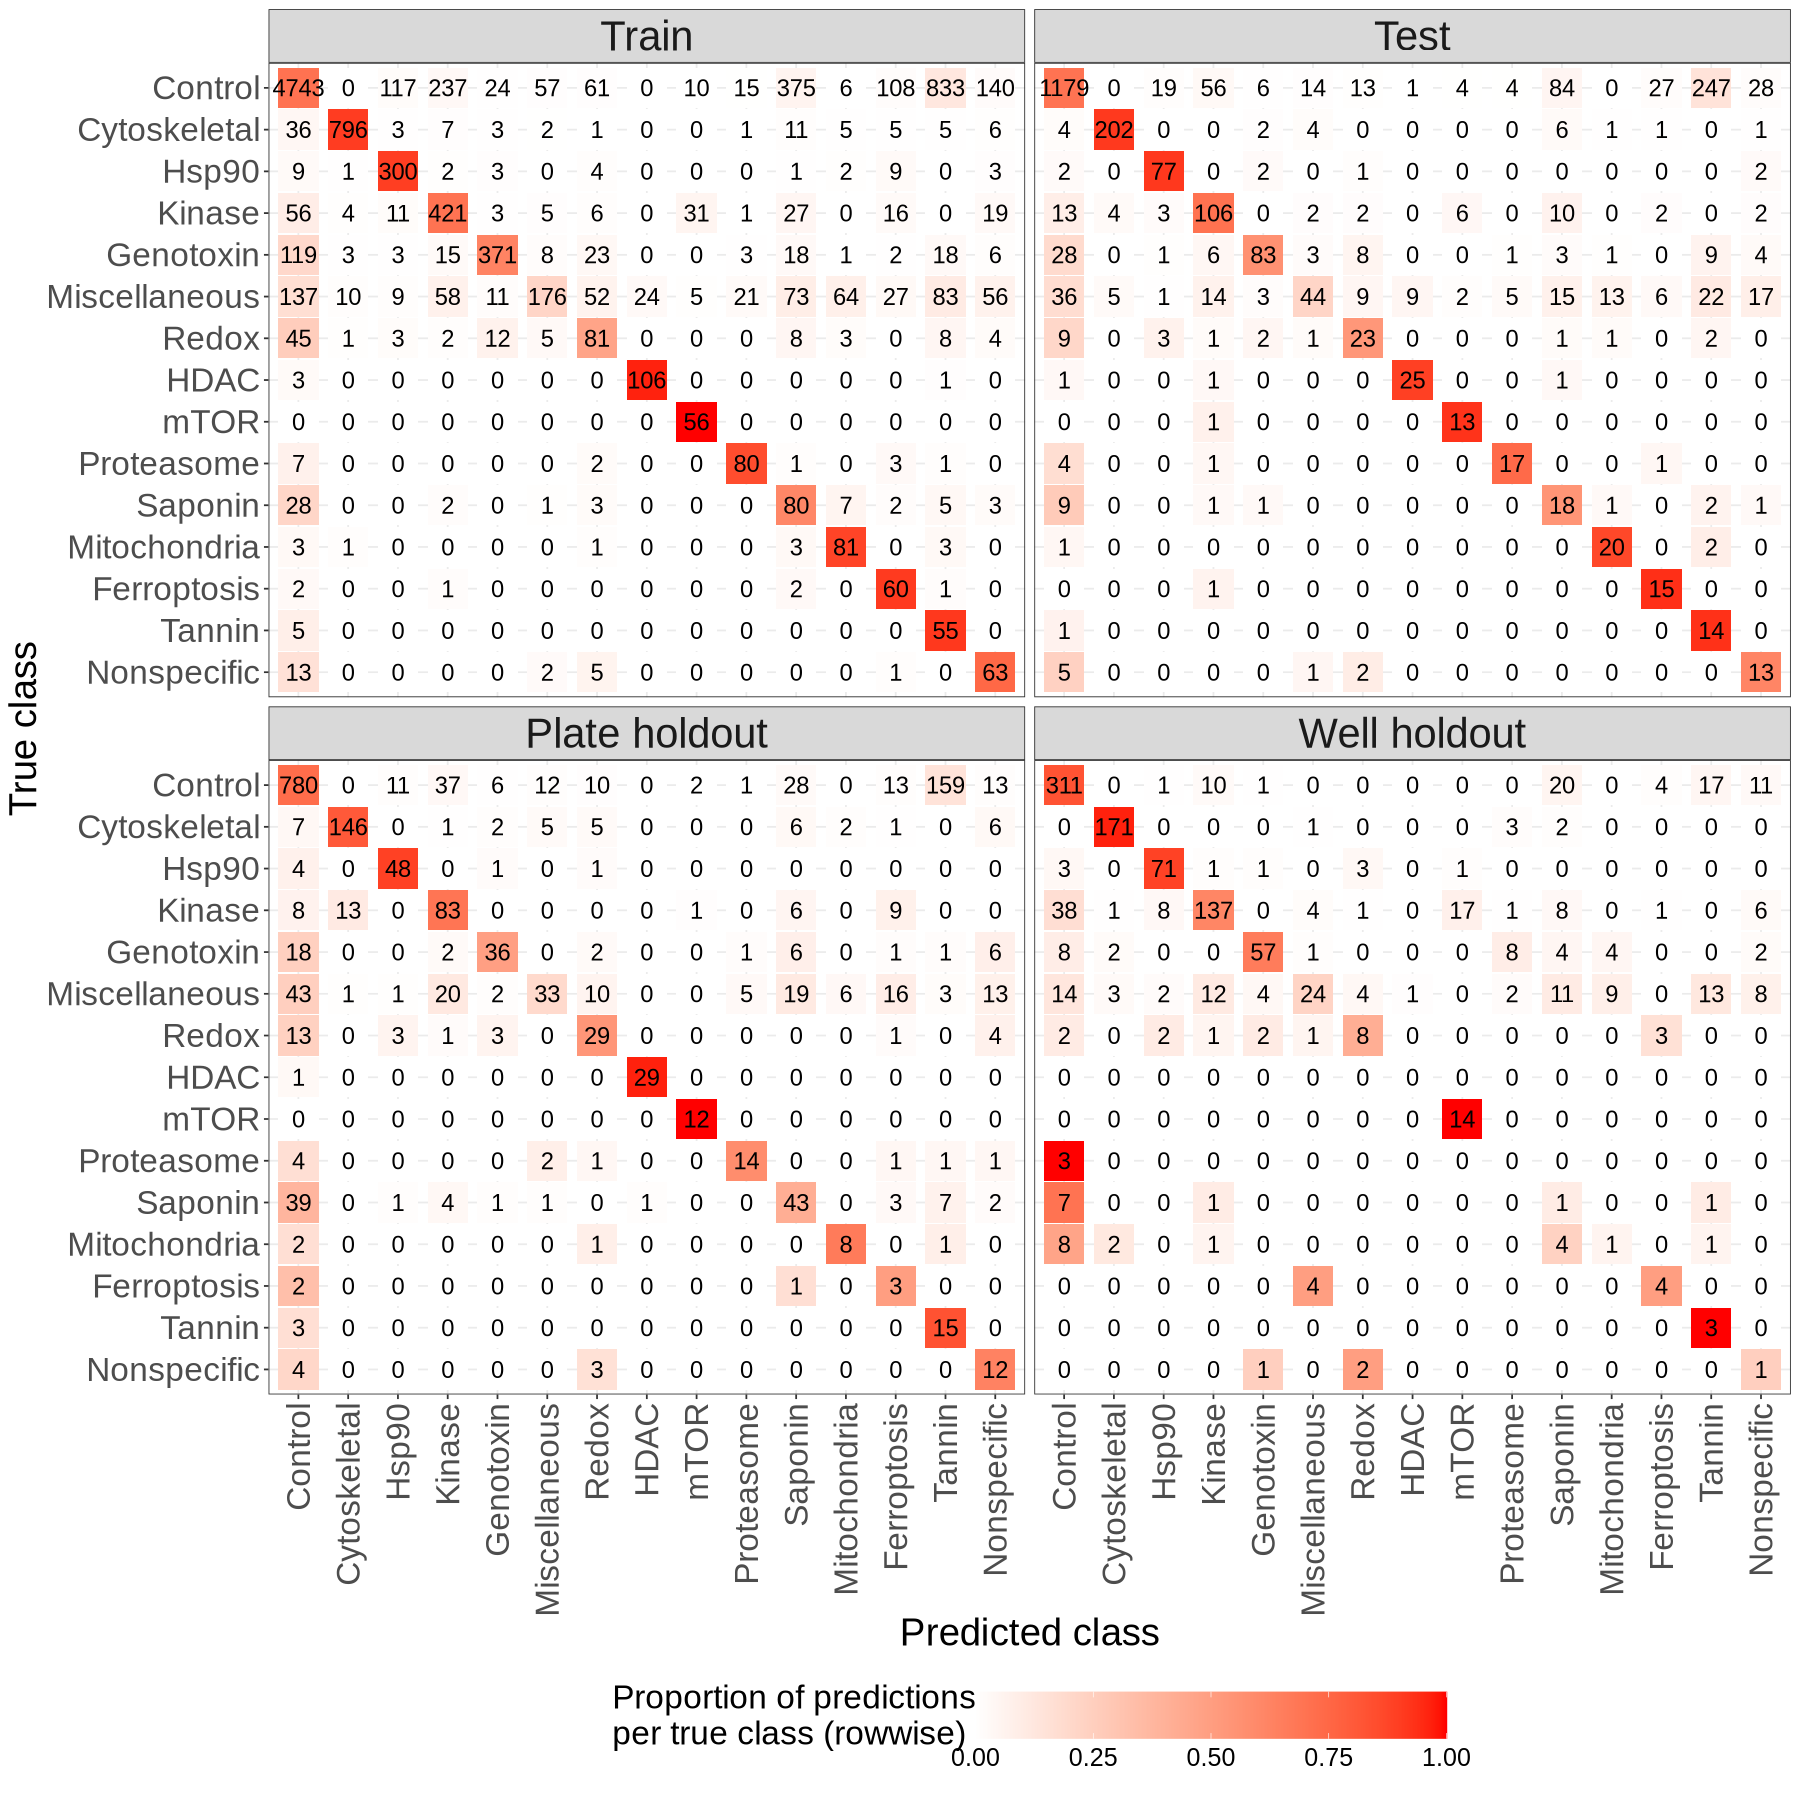

In [11]:
# image size
img_height <- 15
img_width <- 15

options(repr.plot.width = img_width, repr.plot.height = img_height)

# Now proceed with plotting
fig2_C_final_model_cm <- (
    ggplot(final_model_cm, aes(x = predicted_labels, y = true_labels))
    + facet_wrap(~dataset_type)
        + geom_point(aes(color = ratio_rowwise), size = 11, shape = 15)
        + geom_text(aes(label = count), size = 5)
        + scale_color_gradient(
            confusion_matrix_scale_bar_label,
            low = "white",
            high = "red",
            limits = c(0, 1),
            guide = guide_colorbar(
                barheight = unit(1, "cm"),
                barwidth = unit(10, "cm")
            )
        )
        + theme_bw()
        + xlab("Predicted class")
        + ylab("True class")
        + theme(
            # legend settings
            legend.title = element_text(size = 20, margin = margin(b = 20)),
            legend.text = element_text(size = 15),
            legend.position = "bottom", # Move legend to the right to align it vertically
            strip.text = element_text(size = 25),
            axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 20),
            axis.text.y = element_text(hjust = 1, size = 20),
            axis.title.x.bottom = element_text(size = 23),
            axis.title.y.left = element_text(size = 23)
        )
)

# saving file
ggsave(filename = "figures/fig2_C_training_confusion_matrix.png", height = height, width = width, dpi = 600)

fig2_C_final_model_cm

## Supplemental Figure 3: Confusion matrix with Shuffled model 

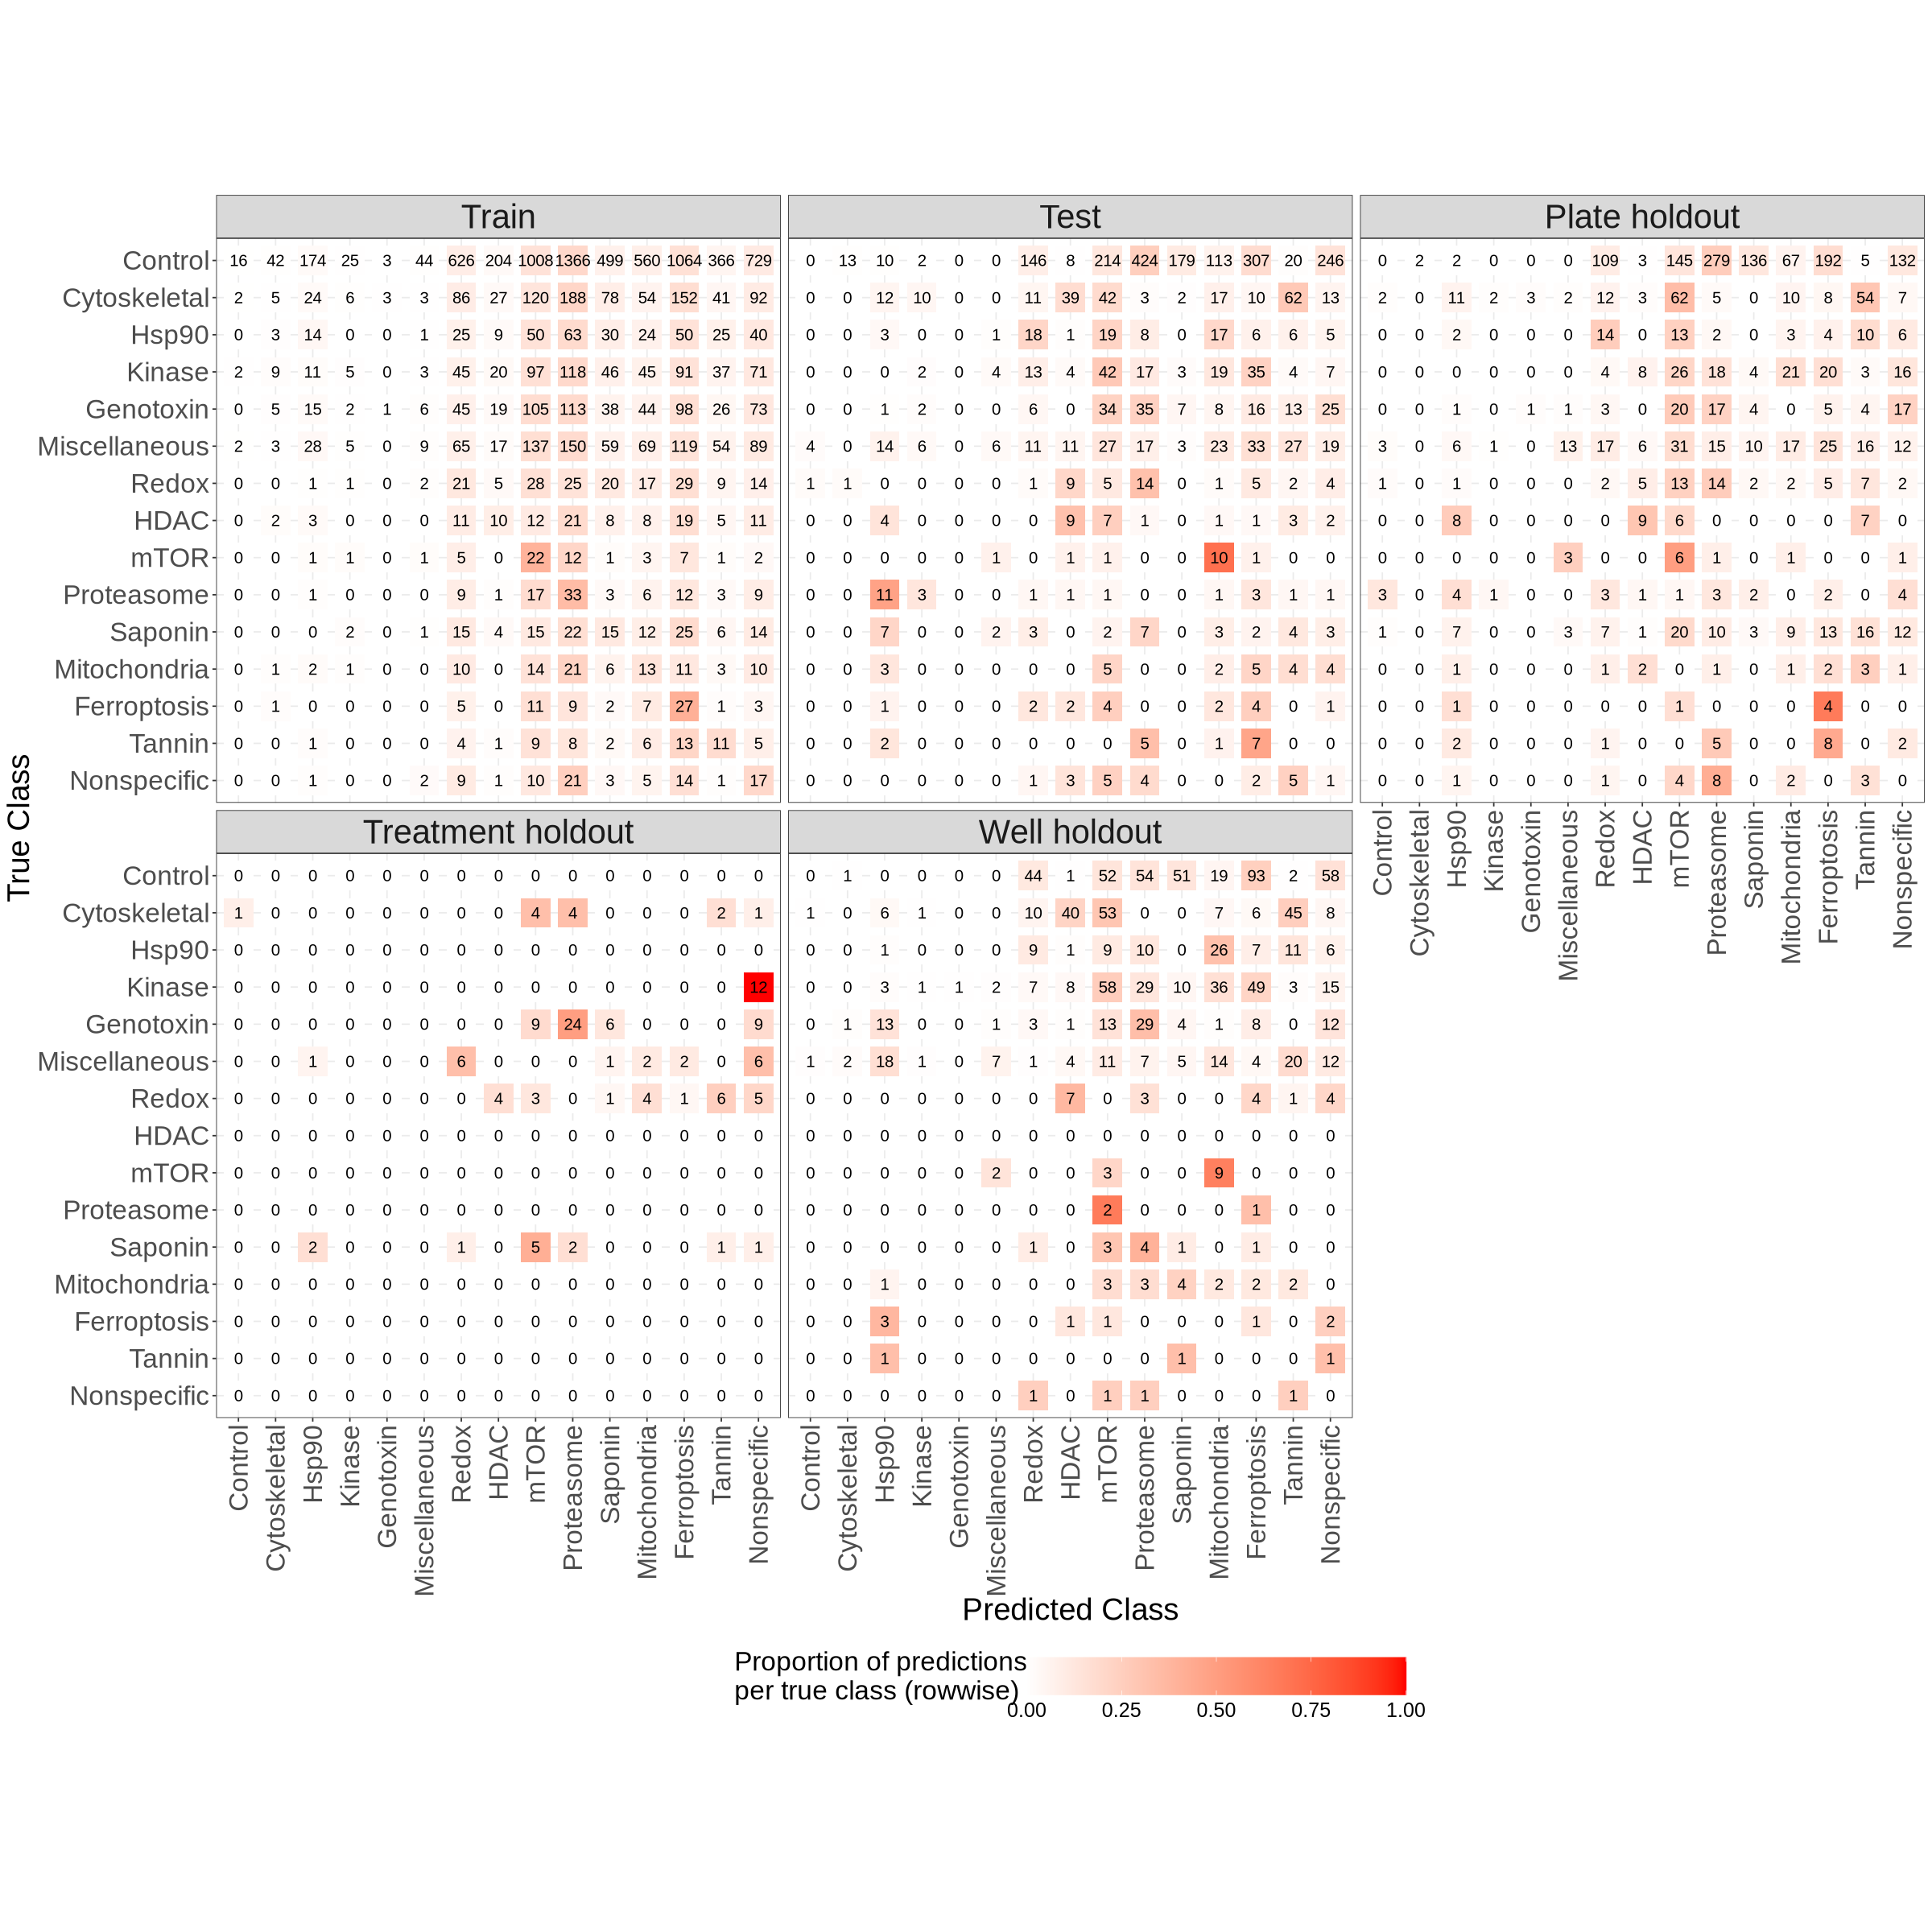

In [12]:
width <- 20
height <- 20
options(repr.plot.width = width, repr.plot.height = height)

# creating final model confusion matrix with Non-shuffled data
final_model_cm <- cm_df %>%
  filter(shuffled_model == "Shuffled" & dataset_type %in% c("Train", "Test", "Plate Holdout", "Treatment Holdout", "Well Holdout")) %>%
  mutate(dataset_type = case_when(
    dataset_type == "Train" ~ "Train",
    dataset_type == "Test" ~ "Test",
    dataset_type == "Plate Holdout" ~ "Plate holdout",
    dataset_type == "Treatment Holdout" ~ "Treatment holdout",
    dataset_type == "Well Holdout" ~ "Well holdout"
  ))

# Reorder the predicted_labels factor variable with the desired order
x_label_order <- c("Control", "Cytoskeletal", "Hsp90", "Kinase", "Genotoxin", "Miscellaneous", "Redox", "HDAC", "mTOR", "Proteasome", "Saponin", "Mitochondria", "Ferroptosis", "Tannin", "Nonspecific")
final_model_cm$true_labels <- factor(final_model_cm$true_labels, levels = rev(unique(final_model_cm$true_labels)))
final_model_cm$predicted_labels <- factor(final_model_cm$predicted_labels, levels = x_label_order)

# Define the desired order of facet levels
facet_order <- c("Train", "Test", "Plate holdout", "Treatment holdout", "Well holdout")
final_model_cm$dataset_type <- factor(final_model_cm$dataset_type, levels = facet_order)

# Calculate rowwise ratios
final_model_cm <- final_model_cm %>%
    dplyr::group_by(dataset_type, shuffled_model, true_labels) %>%
    dplyr::mutate(total_true_count = sum(count)) %>%
    dplyr::mutate(ratio_rowwise = count / total_true_count)

# NA introduced by divide by zero. Convert to zero for plotting purposes
final_model_cm[is.na(final_model_cm$ratio_rowwise), "ratio_rowwise"] <- 0

sfig3_model_cm <- (
  ggplot(final_model_cm, aes(y = true_labels, x = predicted_labels))
    + facet_wrap(~dataset_type)
    + geom_point(aes(color = ratio_rowwise), size = 10, shape = 15)
    + geom_text(aes(label = count), size = 4.3)
    + scale_color_gradient(
        confusion_matrix_scale_bar_label,
        low = "white",
        high = "red",
        limits = c(0, 1),
        guide = guide_colorbar(
            barheight = unit(1, "cm"),
            barwidth = unit(10, "cm")
        )
    )
    + theme_bw()
    + xlab("Predicted Class")
    + ylab("True Class")
    + theme(
      # legend settings
      legend.title = element_text(size = 20, margin = margin(b = 20)),
      legend.text = element_text(size = 15),
      legend.position = "bottom",
      strip.text = element_text(size = 25),
      axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 20),
      axis.text.y = element_text(hjust = 1, size = 20),
      axis.title.x.bottom = element_text(size = 23),
      axis.title.y.left = element_text(size = 23)
    )
    + ggplot2::coord_fixed()
)

# saving file
ggsave(filename = "figures/supplemental/sfig3_shuffled_confusion_matrix.png", height = height, width = width, dpi = 600)

sfig3_model_cm

## Supplemental Figure 4: Confusion matrix of Under Performing Treatment Holdout Predictions 

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


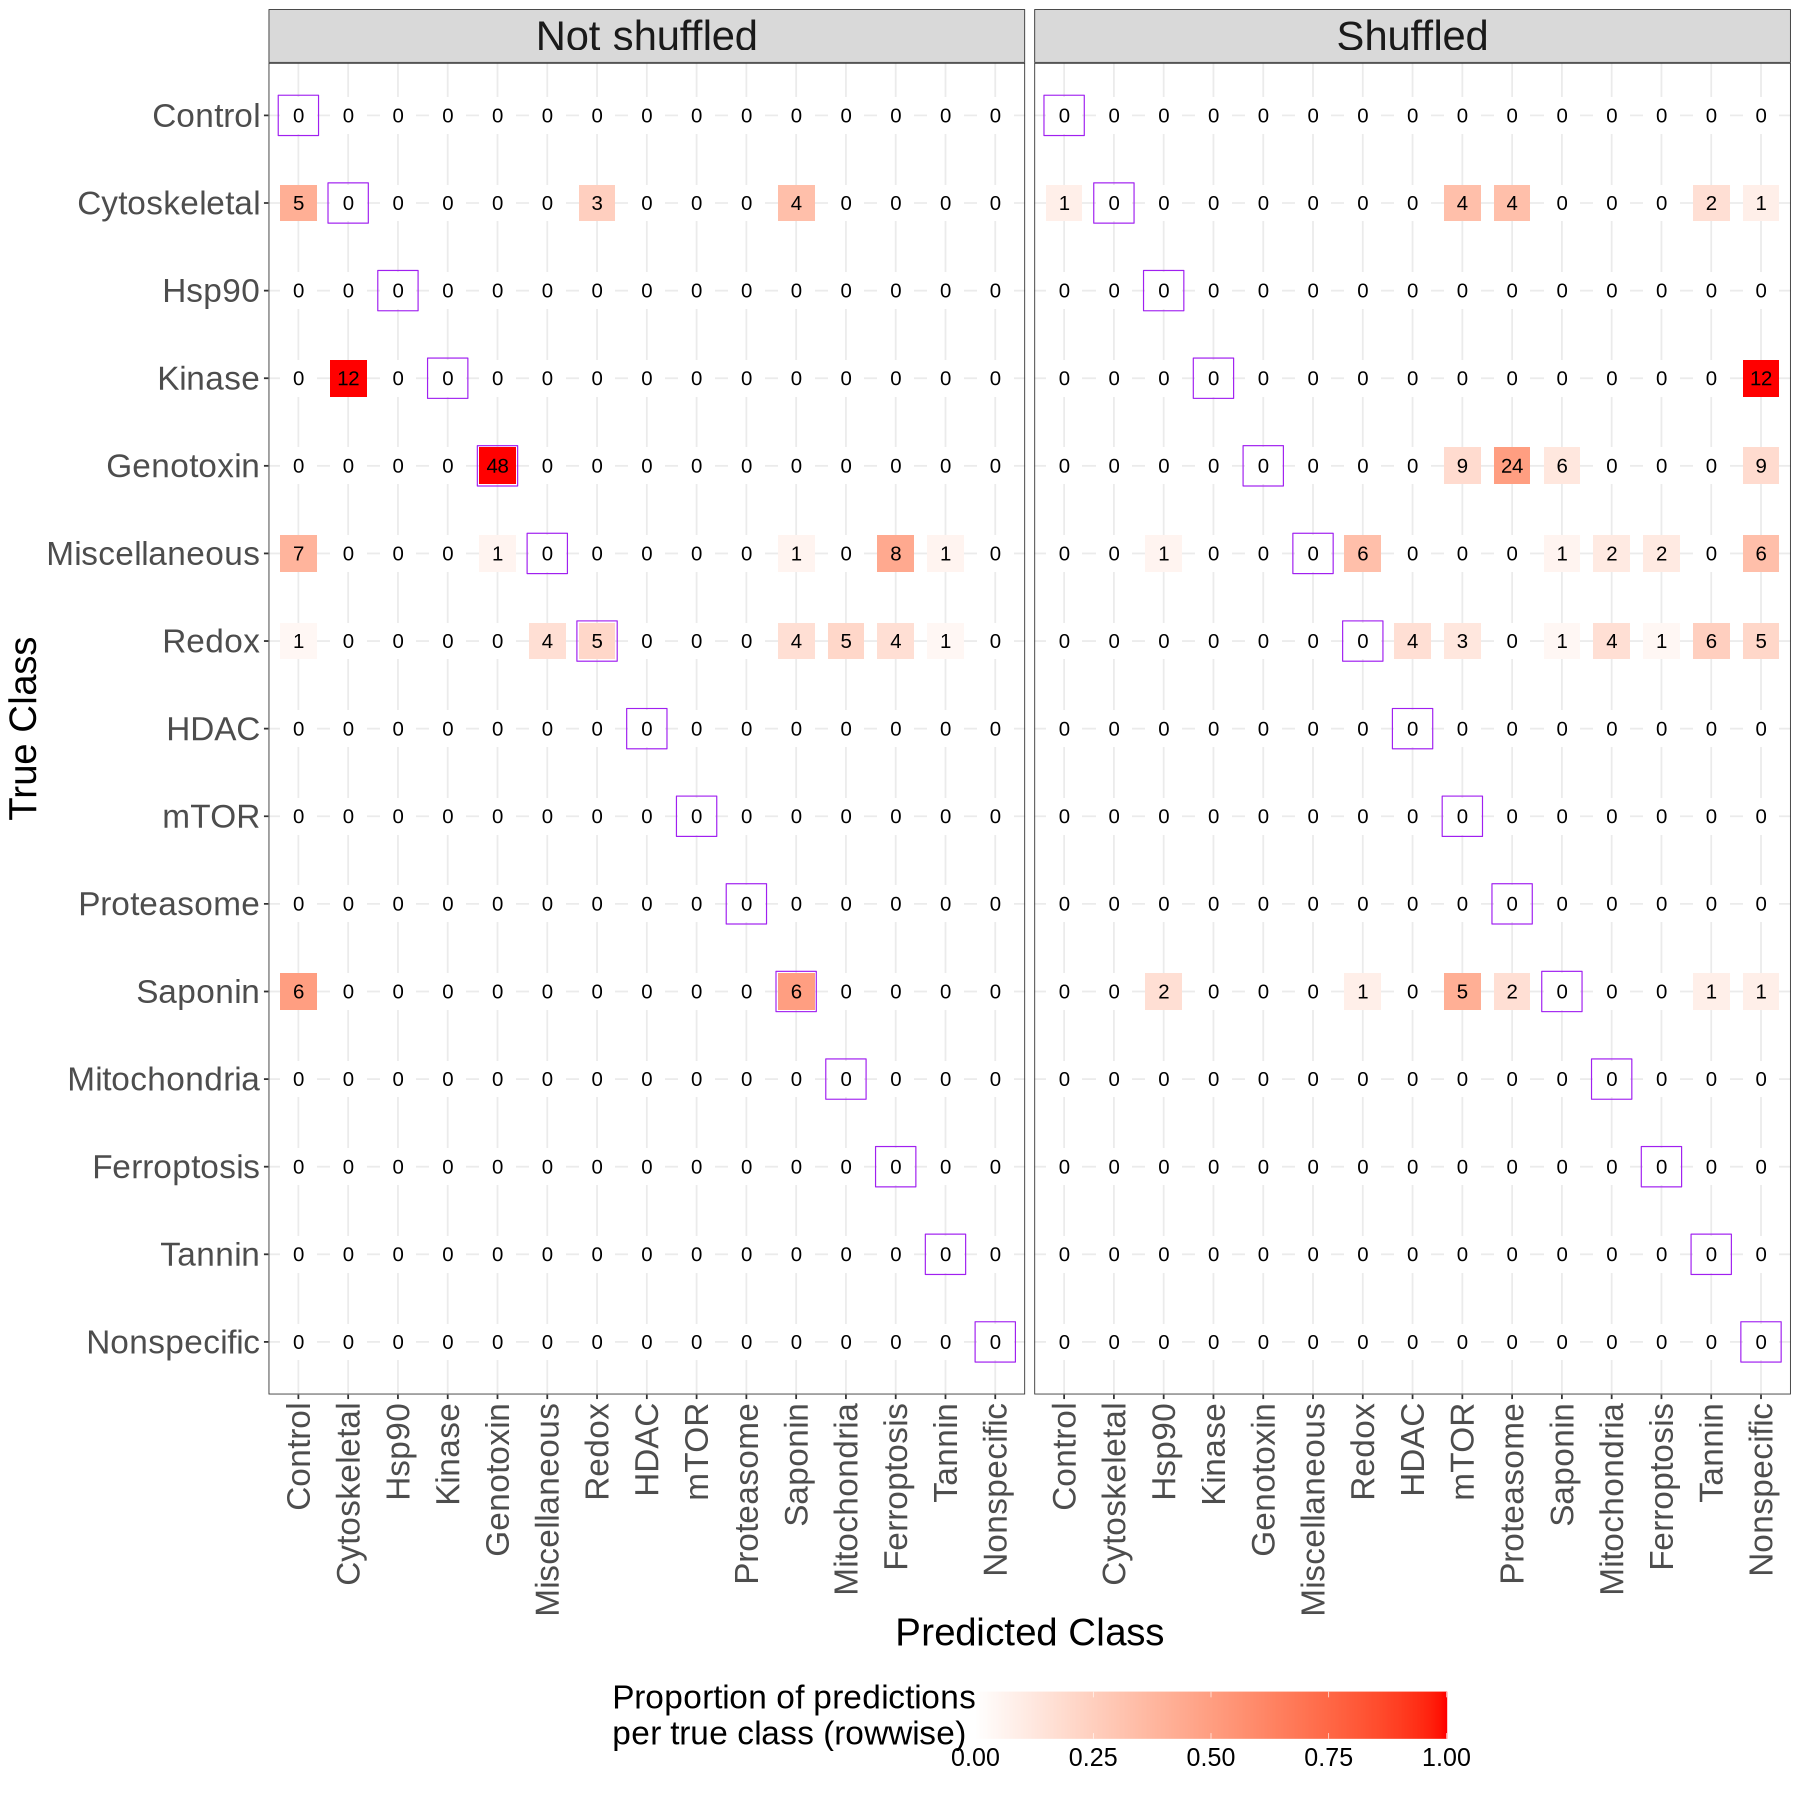

In [13]:
# creating final model confusion matrix with Non-shuffled data
treat_cm <- cm_df %>%
  filter(shuffled_model %in% c("Not Shuffled", "Shuffled") & dataset_type %in% "Treatment Holdout")

# remove Title casing from "Not Shuffled" and edit it to "Not shuffled"
treat_cm$shuffled_model <- ifelse(treat_cm$shuffled_model == "Not Shuffled", "Not shuffled", treat_cm$shuffled_model)

# Define the desired order of x-axis labels
x_label_order <- c("Control", "Cytoskeletal", "Hsp90", "Kinase", "Genotoxin", "Miscellaneous", "Redox", "HDAC", "mTOR", "Proteasome", "Saponin", "Mitochondria", "Ferroptosis", "Tannin", "Nonspecific")

# Reorder the predicted_labels factor variable with the desired order
treat_cm$true_labels <- factor(treat_cm$true_labels, levels = rev(unique(treat_cm$true_labels)))
treat_cm$predicted_labels <- factor(treat_cm$predicted_labels, levels = x_label_order)

# Add a column to indicate if recall is 0 or not
treat_cm$recall_zero <- ifelse(treat_cm$recall == 0, TRUE, FALSE)

# Calculate rowwise ratios
treat_cm <- treat_cm %>%
    dplyr::group_by(dataset_type, shuffled_model, true_labels) %>%
    dplyr::mutate(total_true_count = sum(count)) %>%
    dplyr::mutate(ratio_rowwise = count / total_true_count)

# NA introduced by divide by zero. Convert to zero for plotting purposes
treat_cm[is.na(treat_cm$ratio_rowwise), "ratio_rowwise"] <- 0

# Select only diagonal comparisons so we can draw boxes
focus_correct_predictions_to_draw_boxes <- treat_cm %>%
    dplyr::filter(true_labels == predicted_labels)

# size of plot
width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)

sfig4_treatment_holdout_cm <- (
  ggplot(treat_cm, aes(x = predicted_labels, y = true_labels))
    + facet_wrap(~shuffled_model)
    + scale_color_gradient(
        confusion_matrix_scale_bar_label,
        low = "white",
        high = "red",
        limits = c(0, 1),
        guide = guide_colorbar(
            barheight = unit(1, "cm"),
            barwidth = unit(10, "cm")
        )
    )
    + geom_point(aes(color = ratio_rowwise), size = 10, shape = 15)
    + geom_point(data = focus_correct_predictions_to_draw_boxes, color = "purple", size = 11, shape = 0)
    + geom_text(aes(label = count), size = 4.3)
    + theme_bw()
    + xlab("Predicted Class")
    + ylab("True Class")
    + guides(alpha = FALSE) # Remove the legend for alpha
    + theme(
      # legend settings
      legend.title = element_text(size = 20, margin = margin(b = 20)),
      legend.text = element_text(size = 15),
      legend.position = "bottom",
      strip.text = element_text(size = 25),
      axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 20),
      axis.text.y = element_text(hjust = 1, size = 20),
      axis.title.x.bottom = element_text(size = 23),
      axis.title.y.left = element_text(size = 23)
    )
    )

# saving file
ggsave(filename = "figures/supplemental/sfig4_treatment_holdout_confusion_matrix.png", height = 9, width = 14, dpi = 600)

sfig4_treatment_holdout_cm

## Figure 2 Panel D: Probabilities

Picking joint bandwidth of 0.0221

Picking joint bandwidth of 0.0221



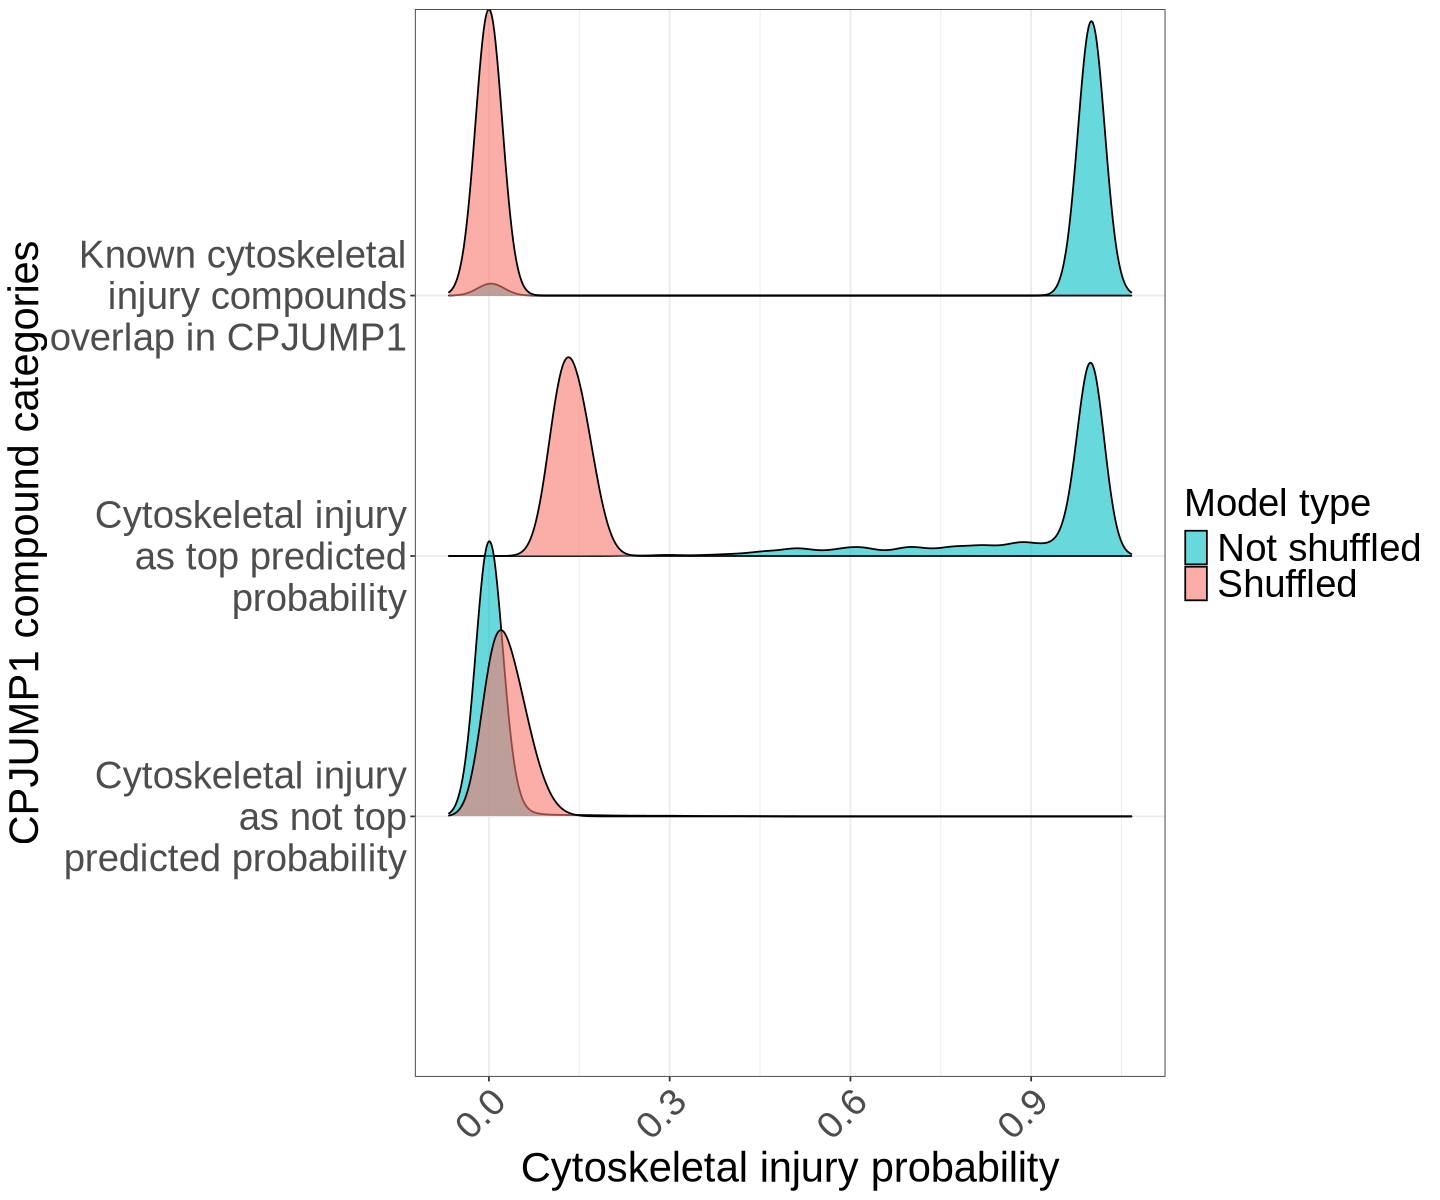

In [14]:
# Define the desired order of y-axis labels
desired_order <- c("Other Injuries", "Cyto Injury", "Cyto JUMP Overlap")

# Define corresponding descriptions for the labels
label_descriptions <- c(
  "Other Injuries" = "Cytoskeletal injury\n as not top\n predicted probability",
  "Cyto Injury" = "Cytoskeletal injury\n as top predicted\n probability",
  "Cyto JUMP Overlap" = "Known cytoskeletal\ninjury compounds\noverlap in CPJUMP1"
)

# Convert the 'injury' variable to factor with the desired order of levels
cyto_proba_df$injury <- factor(cyto_proba_df$injury, levels = desired_order)

# Updating label names
cyto_proba_df <- cyto_proba_df %>%
  mutate(shuffled = ifelse(shuffled == "Not Shuffled", "Not shuffled", shuffled))

img_height <- 10
img_width <- 12

options(repr.plot.width = img_width, repr.plot.height = img_height)

fig2_D_probabilities_ridge_plot <- (
  ggplot(cyto_proba_df, aes(x = Cytoskeletal_proba, y = injury, fill = shuffled)) +
    geom_density_ridges(alpha = 0.6, scale = 1.1) +
    theme_bw() +
    theme(
      axis.text.x = element_text(size = 23, angle = 45, hjust = 1),
      axis.text.y = element_text(size = 23),
      axis.title = element_text(size = 25),
      legend.title = element_text(size = 23),
      legend.text = element_text(size = 23),
      legend.spacing.y = unit(0.1, "cm"),
      legend.box.spacing = unit(0.2, "cm"),
      legend.key.size = unit(0.7, "lines"),
      legend.key.width = unit(1, "lines")
    ) +
    scale_fill_manual(values = c(
      "Shuffled" = "#f8766d",
      "Not shuffled" = "#03bfc4"
    )) +
    labs(
      y = "CPJUMP1 compound categories",
      x = "Cytoskeletal injury probability",
      fill = "Model type"
    ) +
    scale_y_discrete(labels = label_descriptions, expand = expansion(add = c(1, 0)))

)
ggsave(filename = "figures/fig2_D_JUMP_cyto_injury_probability_ridgeplot.png", height = height, width = width, dpi = 600)

fig2_D_probabilities_ridge_plot


In [15]:
# How many points are here?
print(dim(cyto_proba_df))
head(cyto_proba_df)

[1] 38996     5


pred_injury  datatype shuffled     Cytoskeletal_proba injury        
1 Ferroptosis  JUMP     Not shuffled 4.131411e-16       Other Injuries
2 Mitochondria JUMP     Not shuffled 5.142734e-13       Other Injuries
3 Mitochondria JUMP     Not shuffled 5.021454e-10       Other Injuries
4 Mitochondria JUMP     Not shuffled 2.032184e-16       Other Injuries
5 Mitochondria JUMP     Not shuffled 2.847344e-10       Other Injuries
6 Mitochondria JUMP     Not shuffled 7.094783e-12       Other Injuries

## Supplmental Figure 5: Ridge plot of other Injuries

In [16]:
# Subset the dataframe to drop rows where datatype equals "JUMP Overlap"
jump_proba_no_cyto <- subset(all_injury_proba_df, datatype != "JUMP Overlap")

print(dim(jump_proba_no_cyto))
head(jump_proba_no_cyto)

[1] 584220      5


pred_injury  datatype shuffled     injury_compared_to proba       
1 Ferroptosis  JUMP     Not shuffled Control            1.438464e-17
2 Mitochondria JUMP     Not shuffled Control            1.715604e-12
3 Mitochondria JUMP     Not shuffled Control            1.297985e-09
4 Mitochondria JUMP     Not shuffled Control            8.163913e-14
5 Mitochondria JUMP     Not shuffled Control            8.853317e-08
6 Mitochondria JUMP     Not shuffled Control            1.646288e-10

In [17]:
# Define image dimensions
img_height <- 5
img_width <- 12

options(repr.plot.width = img_width, repr.plot.height = img_height)

# setting class order
class_order <- c("Control", "Cytoskeletal", "Hsp90", "Kinase", "Genotoxin", "Miscellaneous", "Redox", "HDAC", "mTOR", "Proteasome", "Saponin", "Mitochondria", "Ferroptosis", "Tannin", "Nonspecific")

# storing legend object
legend_plot <- list()
# storing plots
ridge_plots_list <- list()


# Loop through each class
for (i in 1:length(class_order)) {
  class <- class_order[i]

  # Skip if the class is "Cytoskeletal" since it's in the panel
  if (class == "Cytoskeletal") {
    next # Skip to the next iteration of the loop
  }

  # Sub-dataframe for equal pred_injury and injury_compared_to
  # Add a column indicating the rows are matched and rename it to "label"
  equal_df <- jump_proba_no_cyto[jump_proba_no_cyto$pred_injury == class & jump_proba_no_cyto$injury_compared_to == class, ]
  equal_df <- equal_df %>%
    mutate(label = "Wells predicted\nas selected injury")

  # Sub-dataframe for not equal pred_injury and injury_compared_to
  # Add a column indicating the rows are not matched and rename it to "label"
  not_equal_df <- jump_proba_no_cyto[jump_proba_no_cyto$injury_compared_to == class & jump_proba_no_cyto$pred_injury != class, ]
  not_equal_df <- not_equal_df %>%
    mutate(label = "Wells not predicted\nas selected injury")

  # Concatenate the two dataframes after rearranging the rows
  concatenated_class_df <- rbind(equal_df, not_equal_df)

  # Count index per class
  index_count <- sum(jump_proba_no_cyto$pred_injury == class & jump_proba_no_cyto$injury_compared_to == class) +
    sum(jump_proba_no_cyto$injury_compared_to == class & jump_proba_no_cyto$pred_injury != class)

  # Create ridge plot for the concatenated dataframe
  ridge_plot <- ggplot(concatenated_class_df, aes(x = proba, y = label, fill = shuffled)) +
    geom_density_ridges(alpha = 0.6) +
    theme_bw() +
    labs(title = paste(class, "injury"), fill = "Model type: ") +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_text(size = 20),
      # axis.text.x = element_text(size = 20, angle = 45, hjust = 1),
      axis.text.y = element_text(size = 20),
      axis.title = element_text(size = 22),
      axis.title.y = element_blank(),
      plot.title = element_text(size = 23, hjust = 0.5, face = "bold"),
      legend.title = element_text(size = 20),
      legend.text = element_text(size = 20),
      legend.spacing.y = unit(0.1, "cm"),
      legend.box.spacing = unit(0.2, "cm"),
      legend.key.size = unit(0.7, "lines"),
      legend.key.width = unit(1, "lines"),
      legend.position = "none"
    ) +
    scale_fill_manual(values = c(
      "Shuffled" = "#f8766d",
      "Not shuffled" = "#03bfc4"
    )) +
    scale_x_continuous(breaks = seq(0, 1, by = 0.25))

  # add margin top of title except for the last two
  if (i != 14 && i != 15) {
    ridge_plot <- ridge_plot + theme(
      plot.title = element_text(hjust = 0.5, margin = margin(t = 20))
    )
  }

  # remove x label ticks of if not these indexes
  if (!(i %in% c(13, 14, 15))) {
    ridge_plot <- ridge_plot + theme(axis.text.x = element_blank())
  }

  # remove y label ticks if not these indexes
  if (!(i %in% c(1, 5, 8, 11, 14))) {
    ridge_plot <- ridge_plot + theme(axis.text.y = element_blank())
  }

  # add legend on the last subplot
  if (i == 15) {
    ridge_plot <- ridge_plot +
  labs(x = "Probabilities") +  # Move the label to the bottom
  theme(
    axis.title.x = element_text(size = 30, margin = margin(t = 10), face = "bold"),  # Add the title at the bottom
    # axis.title.x = element_blank(),  # Add the title at the bottom
    axis.title.y = element_blank(),  # Remove the y-axis title
    axis.text.x = element_text(size = 20),  # Ensure y-axis labels are visible
    legend.position = "bottom",
    legend.title = element_text(size = 30),
    legend.text = element_text(size = 25),
    legend.margin = margin(t = 25)
  )
  }

  # storing plots
  ridge_plots_list[[class]] <- ridge_plot
}

Picking joint bandwidth of 0.015

Picking joint bandwidth of 0.0244

Picking joint bandwidth of 0.012

Picking joint bandwidth of 0.0114

Picking joint bandwidth of 0.0214

Picking joint bandwidth of 0.031

Picking joint bandwidth of 0.0243

Picking joint bandwidth of 0.0226

Picking joint bandwidth of 0.0291

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0204

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0217

Picking joint bandwidth of 0.0213

Picking joint bandwidth of 0.015

Picking joint bandwidth of 0.0244

Picking joint bandwidth of 0.012

Picking joint bandwidth of 0.0114

Picking joint bandwidth of 0.0214

Picking joint bandwidth of 0.031

Picking joint bandwidth of 0.0243

Picking joint bandwidth of 0.0226

Picking joint bandwidth of 0.0291

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0204

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0217

Picking joint bandwidth of 0.0213



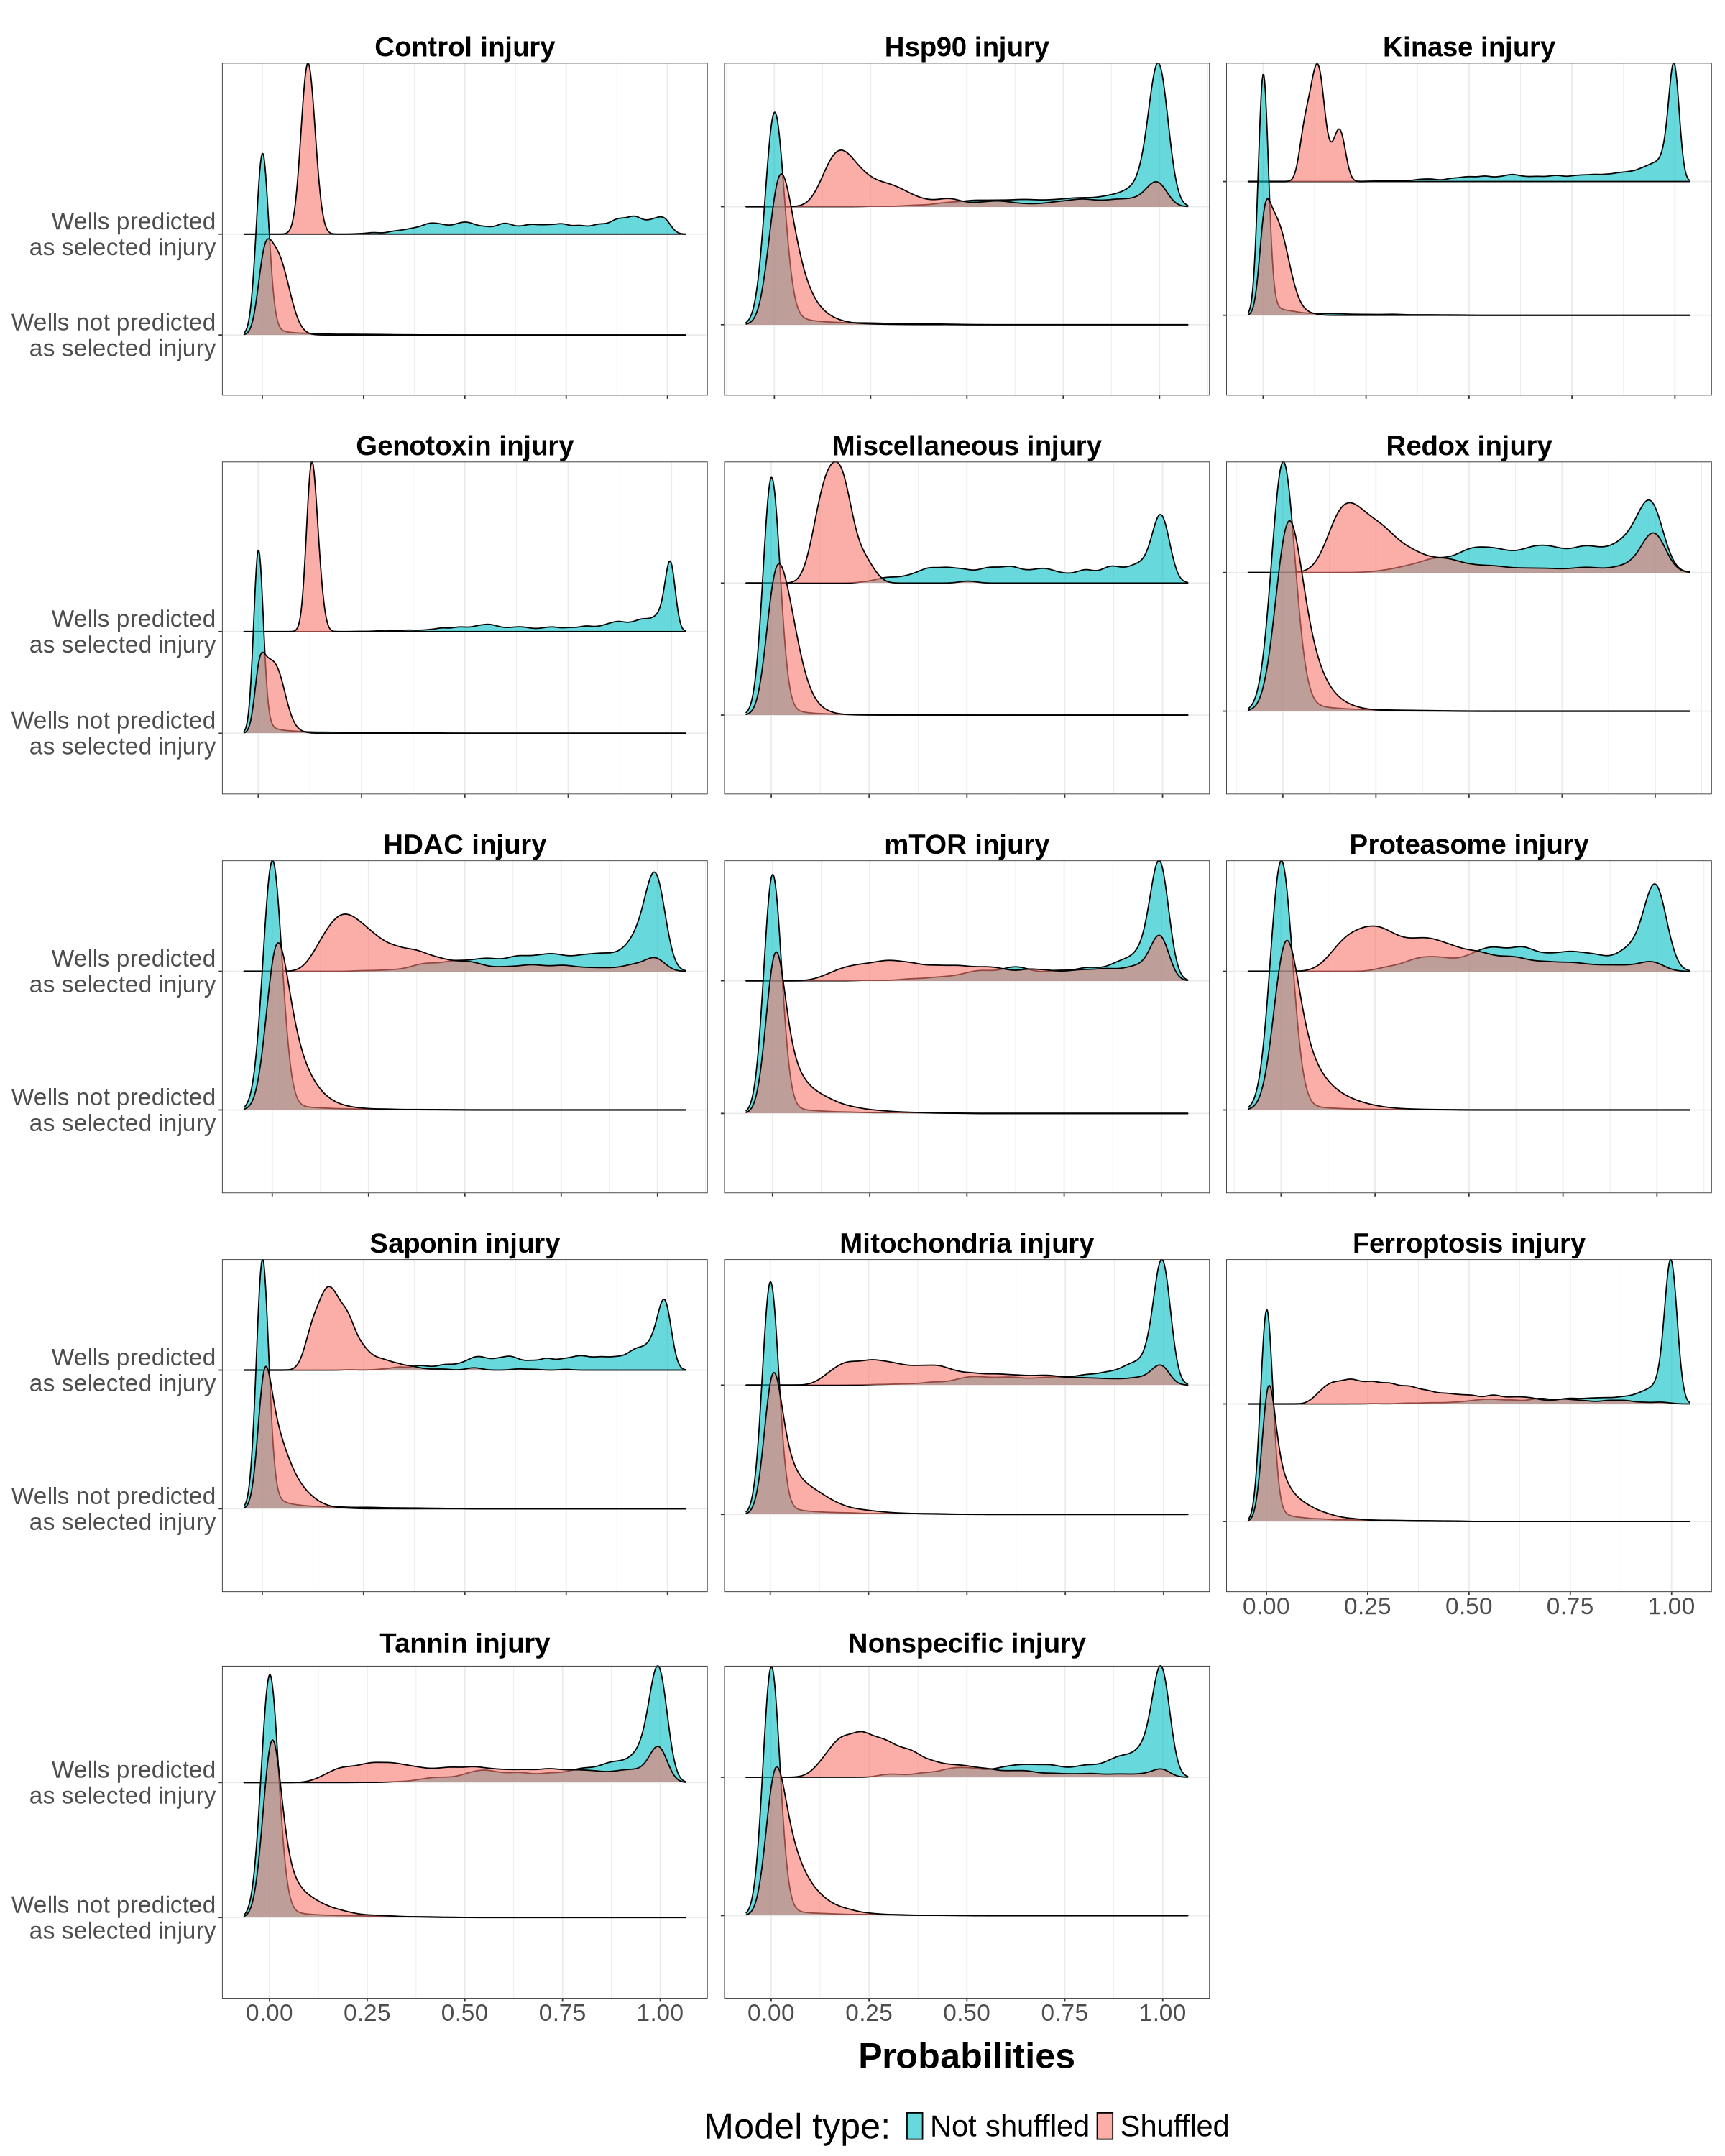

In [18]:
img_height <- 25
img_width <- 20

options(repr.plot.width = img_width, repr.plot.height = img_height)

# Convert the list of ridge plots to a patchwork layout
all_injury_probas_ridge_plot <- wrap_plots(ridge_plots_list[1:14], ncol = 3)

# Print the combined ridge plots
all_injury_probas_ridge_plot

# Save the plot
ggsave(
  plot = all_injury_probas_ridge_plot,
  filename = "figures/supplemental/sfig5_all_injury_probabilities.png",
  height = img_height,
  width = img_width,
  dpi = 700
)

## Finalizing figure 2 with patchwork

Picking joint bandwidth of 0.0221

Picking joint bandwidth of 0.0221



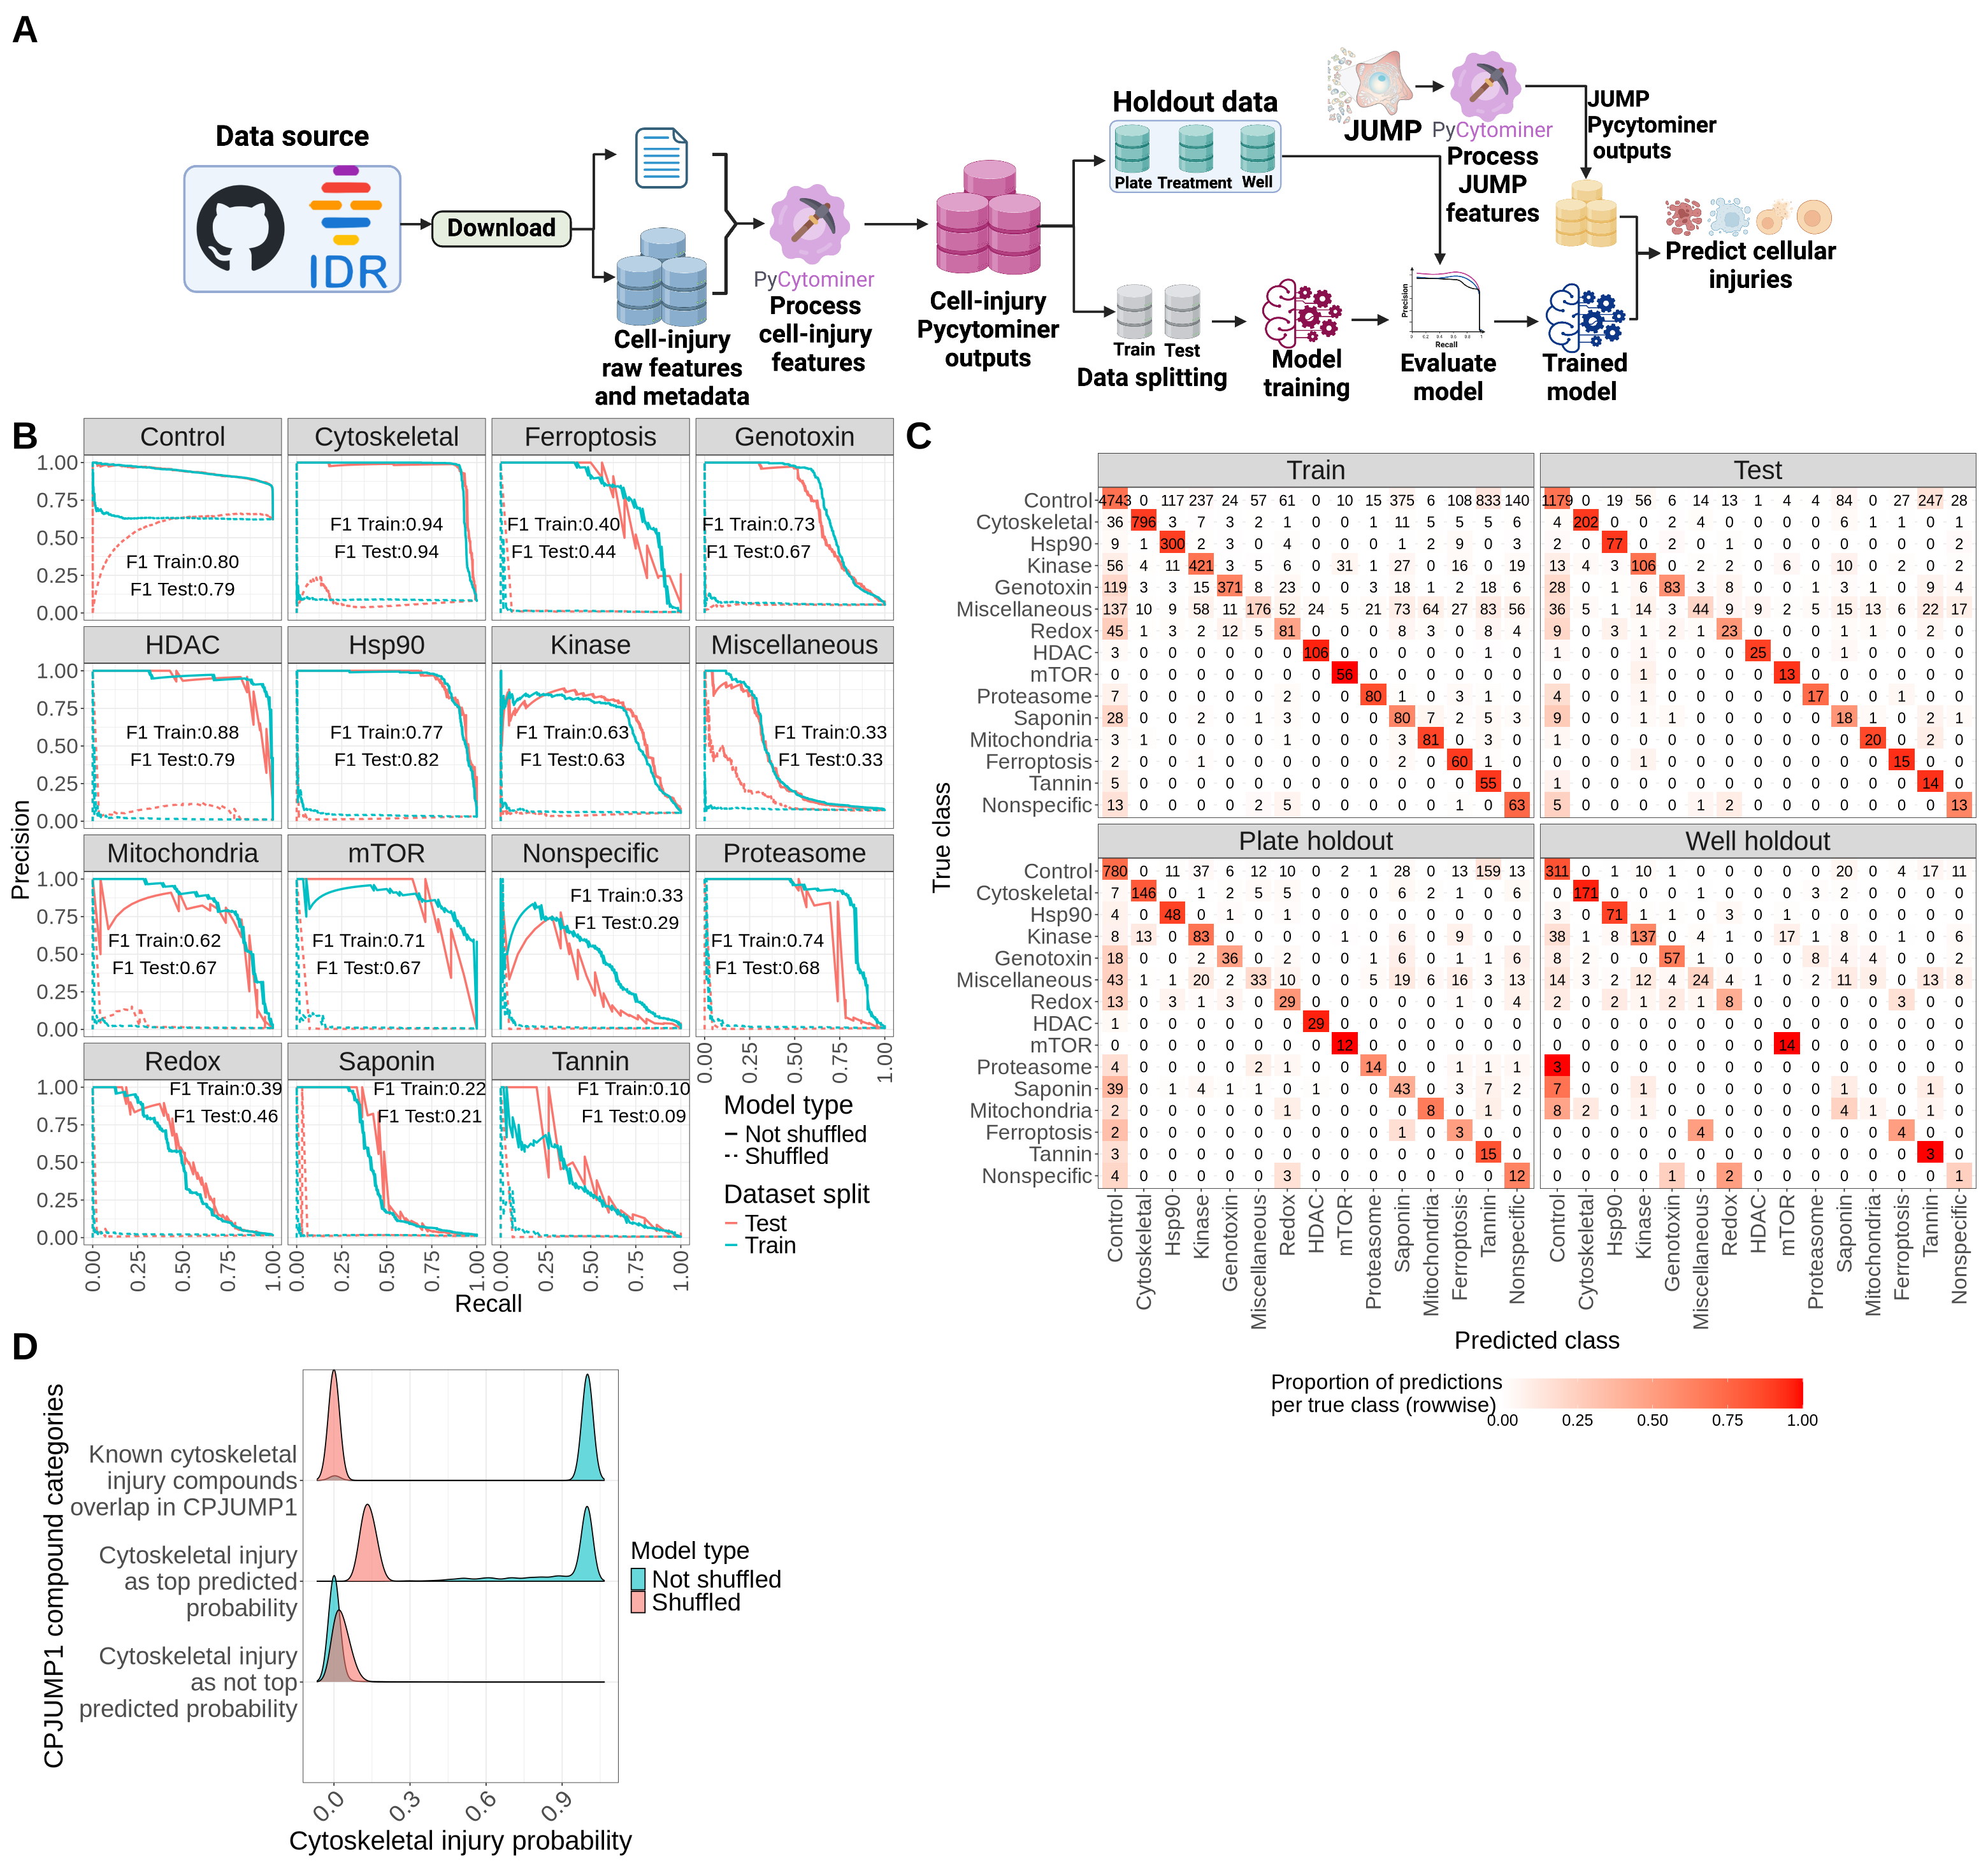

In [19]:
# Define plot dimensions
height = 24.5
width = 26

layout <- c(
    # Row 1
    area(t=0, b=5, l=0, r=20), # A

    # row 2
    area(t=6, b=18, l=0, r=9), # B
    area(t=6, b=19, l=10, r=20), # C

    # row 3
    area(t=19, b=25, l=0, r=8), # D
    area(t=20, b=25, l=11, r=20) # empty space
)
options(repr.plot.width=width, repr.plot.height=height, units = "in", dpi = 600)

fig2 <- (
    wrap_elements(fig2_A_wf_image)
    / wrap_elements( full = fig2_B_pr_curve_plot_train_test)
    + free(fig2_C_final_model_cm)
    + wrap_elements(fig2_D_probabilities_ridge_plot)
    + plot_spacer()

    # plot layouts
    + plot_layout(design = layout, heights = c(3, 3, 1.85))  # Freeze Row 2 with a higher relative height (3)

    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 35, face = "bold"))
)

# Display the combined plot
fig2

# # Save the plot
ggsave(
  plot = fig2,
  filename = "figures/Final_Figure2.png",
  height = height,
  width = width,
  dpi = 700
)